# Inverse design plugin

This notebook introduces the "Inverse Design" (`invdes`) plugin of Tidy3D.

The goal of `invdes` is to provide a simpler interface for setting up most practical inverse design problems. It wraps the lower-level `autograd` support of Tidy3D to perform the gradient calculations, but allows the user to focus on the important aspects of their design without getting into the details of `autograd`.

In this notebook, we'll give a simple demo showing the inverse design of a 1 -> 3 splitter using the inverse design plugin.

<img src="img/invdes.png" width="700" alt="InverseDesignWorkflow">

We first import our main packages, note that we will import the `invdes` plugin as `tdi` to make it easy to access.

In [1]:
import matplotlib.pylab as plt
import numpy as np

import tidy3d as td
import tidy3d.plugins.invdes as tdi

## Setting Up the Inverse Design problem

The `invdes` problem works by constructing an `InverseDesign` object that contains all of the information about the problem we wish to optimize. This includes some base information about the simulation itself, information about the design region, and which monitors our objective will depend on. We then run the `InverseDesign` object using an `Optimizer`, which returns an object that can be analyzed or used to continue the optimization, as needed.

In the next few cells we will define all of the components we need to make an `InverseDesign`, but to start we will define some global parameters used throughout the notebook.

```
       |---------|===== -> 
       |         |
-> ====+         |===== ->
       |         |
       |---------|===== -> 
```

In [2]:
# source info
wavelength = 1.0

# waveguide parameters
num_output_waveguides = 3
ly_wg = 0.5 * wavelength
buffer_wg = 0.9 * wavelength

# buffer between design region, pml, and sources
buffer = 1 * wavelength

# relative permittivity of material
eps_mat = 4.0

# resolution (for both the FDTD simulation and for the design region)
min_steps_per_wvl = 30
pixel_size = wavelength / min_steps_per_wvl / np.sqrt(eps_mat)

Next we define some quantities derived from these parameters.

In [3]:
# spectral information
freq0 = td.C_0 / wavelength
fwidth = freq0 / 10
run_time = 50 / fwidth

# design region size in y
ly_des = num_output_waveguides * (ly_wg + buffer_wg)
lx_des = 4 * wavelength

# simulation size
Lx = 2 * buffer + lx_des + 2 * buffer
Ly = buffer + ly_des + buffer

# source and monitor locations
x_src = -lx_des/2 - buffer
x_mnt = -x_src

# material Medium
medium = td.Medium(permittivity=eps_mat)

# grid spec
grid_spec = td.GridSpec.auto(wavelength=wavelength, min_steps_per_wvl=min_steps_per_wvl)

# monitor names
def output_monitor_name(i: int) -> str:
    return f"MNT_{i}"

field_mnt_name = "field"

# mode spec
mode_spec = td.ModeSpec(num_modes=1)

### Define Base Simulation

Next we want to define the base `td.Simulation` that contains the static portions of our inverse design problem.

For this, we will make a bunch of regular `tidy3d` components (excluding the design region) and put them into a `td.Simulation`.


In [4]:
waveguide_in = td.Structure(
    geometry=td.Box(
        size=(Lx, ly_wg, td.inf),
        center=(-Lx + 2 * buffer, 0, 0),
    ),
    medium=medium,
)

In [5]:
y_max_wg_centers = ly_des / 2 - buffer_wg / 2 - ly_wg / 2
wg_y_centers_out = np.linspace(-y_max_wg_centers, y_max_wg_centers, num_output_waveguides)

# put a waveguide and mode monitor at each of the outputs
waveguides_out = []
monitors_out = []
for i, wg_y_center in enumerate(wg_y_centers_out):

    wg_out = td.Structure(
        geometry=td.Box(
            size=(Lx, ly_wg, td.inf),
            center=(Lx - 2 * buffer, wg_y_center, 0),
        ),
        medium=medium,
    )

    waveguides_out.append(wg_out)

    mnt_out = td.ModeMonitor(
        size=(0, ly_wg + 1.8 * buffer_wg, td.inf),
        center=(x_mnt, wg_y_center, 0),
        freqs=[freq0],
        name=output_monitor_name(i),
        mode_spec=mode_spec,
    )

    monitors_out.append(mnt_out)

In [6]:
source = td.ModeSource(
    size=(0, ly_wg + 1.8 * buffer_wg, td.inf),
    center=(x_src, 0, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    mode_index=0,
    direction="+",
)

# used to visualize fields in the plane, not for optimization
fld_mnt = td.FieldMonitor(
    center=(0,0,0),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name=field_mnt_name,
)

In [7]:
simulation = td.Simulation(
    size=(Lx, Ly, 0),
    grid_spec=grid_spec,
    boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=False),
    run_time=run_time,
    structures=[waveguide_in] + waveguides_out,
    sources=[source],
    monitors=[fld_mnt] + monitors_out,
)

Let's visualize our base simulation.

> Note: we have not added a design region yet, so for now we will draw an empty rectangle to indicate where that will go.

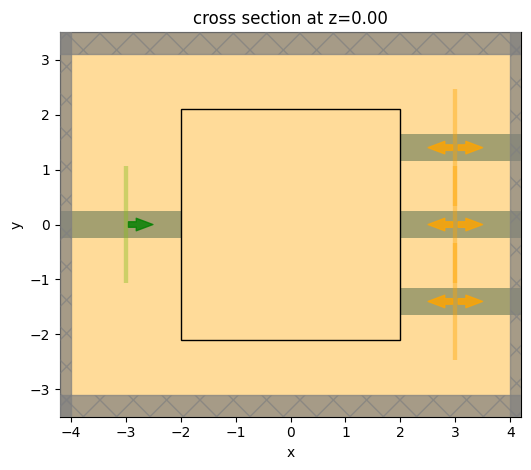

In [8]:
ax = simulation.plot(z=0)

import matplotlib
rect = matplotlib.patches.Rectangle(xy=(-lx_des/2, -ly_des/2), width=lx_des, height=ly_des, fill=None)
ax.add_patch(rect)
plt.show()

Note that our simulation is lacking a central coupling region. We will define that in the next step.

### Define the Design Region

Next, we will introduce the `DesignRegion` component of the `invdes` plugin. This component contains fields that describe the design region and how it is rendered into a `td.Structure` as a function of the optimization design parameters.

For now, we only support "topology optimization" design structures (pixellated permittivity grids) through a `TopologyDesignRegion`, but in future versions we will introduce shape and level-set design regions.

The `TopologyDesignRegion` combines geometric information (size, center) about the design region with some information describing the pixellated grid. Furthermore, it also accepts a list of transformations and penalties, which respectively determine how the permittivity is rendered and how the optimization will penalize various expressions of the design region. We will explore each of the features below.

#### Discretization

The `TopologyDesignRegion` contains a `pixel_size` parameter, which sets the resolution of the permittivity grid and also determines the shape of the parameter array. 

The `pixel_size` is also passed to the various penalties and transformations to allow them to work properly with the design region.

If not specified in a later step, this `pixel_size` will be used to set the FDTD grid size of the structure in the final `Simulation`. It is therefore a good idea to either set it to a low value (about equal to the simulation grid cell size) or manually set the mesh override structure resolution in the `TopologyDesignRegion.mesh_override_dl` field to overwrite it.

#### Transformations
The `TopologyDesignRegion.transformations` are specifications that tell the design region how to transform the supplied optimization parameters into a "material density" that is used to construct the permittivity grid. For example, a `FilterProject` transformation applies a conic filter convolution followed by a hyperbolic tangent function projection. If multiple transformations are added to the design region, they will be evaluated one by one, from beginning to end, on the optimization parameters.

#### Penalties
The `TopologyDesignRegion.penalties` are specifications that tell the optimizer how to penalize the material density corresponding to this design region. For example, an `ErosionDilation` penalty will look at the material density of the region (state of the parameters after all transformations have completed) and evaluate it based on whether the material density is invariant under erosion and dilation, a good proxy for feature size compatibility. Penalties have a `.weight` that can be used to tune their relative contribution to the objective. The total penalty contribution to the objective function is the weighted sum of penalties added to the design region.

> Note: the convention used is that we wish to **maximize** our objective function. Penalties **subtract** from the objective. Therefore, a positive penalty `weight` corresponds to a negative contribution to the objective function.

In [9]:
# radius (um) of the conic filter that is convolved with th parameter array.
# Larger values tend to help create larger feature sizes in the final device.
projection_radius = 0.120

# projection strength, larger values lead to more binarization and tend to push intermediate parameters towards (0,1) density
beta = 10.0

# transformations on the parameters that lead to the material density array (0,1)
filter_project = tdi.FilterProject(radius=projection_radius, beta=beta)

# length scale (um) of the erosion dilation penalty.
# features smaller than this scale will be penalized
length_scale = 0.120

# penalty weight, the penalty contributes its raw value (max of 1) times this weight to the objective function
weight = 0.8

# penalties applied to the state of the material density, after these transformations are applied
penalty = tdi.ErosionDilationPenalty(weight=weight, length_scale=length_scale)

design_region = tdi.TopologyDesignRegion(
        size=(lx_des, ly_des, td.inf),
        center=(0, 0, 0),
        eps_bounds=(1.0, eps_mat), # the minimum and maximum permittivity values in the final grid
        transformations=[filter_project],
        penalties=[penalty],
        pixel_size=pixel_size,
    )

### Getting Parameter Arrays

When optimizing, we will update an array of design parameters. Therefore, the `DesignRegion` accepts an array of these parameters when being converted to tidy3d `Structure` objects or when evaluating penalties or the material density values.

The shape of this array is automatically determined by the geometric parameters and `pixel_size` of the `TopologyDesignRegion`. This shape can be accessed as a `tuple` from `design_region.params_shape`. 

To make it convenient to initialize parameter arrays of the proper shape, there are a few properties of the `TopologyDesignRegion` instance:

* `TopologyDesignRegion.params_random` (creates an array uniformly sampled at random between 0 and 1)

* `TopologyDesignRegion.params_ones` (creates an array of all 1)

* `TopologyDesignRegion.params_zeros` (creates an array of all 0)

These properties can be combined together to conveniently set up your parameter array, for example:

In [10]:
params0 = design_region.params_random
params0 += np.fliplr(params0)
params0 /= 2
print(params0.shape)

(240, 252, 1)


### Converting to Structures

Given an array of parameter values, this `TopologyDesignRegion` object can be exported to an equivalent `td.Structure`.

Here's an example using the `params0` array we just defined.

In [11]:
structure = design_region.to_structure(params0)

Let's plot the permittivity values of the custom medium contained in this structure.

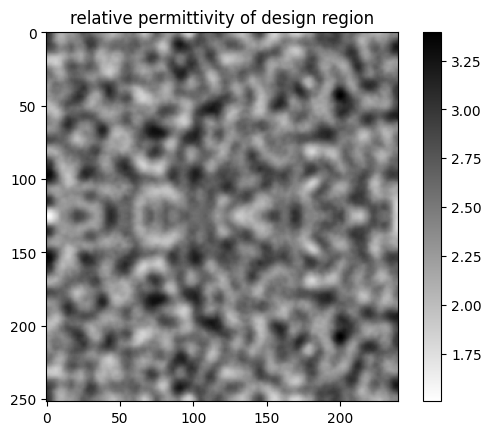

In [12]:
eps_arr = structure.medium.permittivity.values
im = plt.imshow(eps_arr.squeeze().T, cmap="binary")
plt.colorbar(im)
plt.title('relative permittivity of design region')
plt.show()

We can see the influence of the `FilterProject` object in smoothing out the features.

## Inverse Design object

Next, we put the design region, simulation, and post-processing function together into an `InverseDesign` object, which captures everything we need to define our inverse design problem before running it.

In [13]:
design = tdi.InverseDesign(
    simulation=simulation,
    design_region=design_region,
    task_name="invdes",
    output_monitor_names=[mnt.name for mnt in monitors_out],
)

> Note: the `output_monitor_names` field is used to specify which monitors to use in the objective function. If they are not supplied, `invdes` will automatically include all compatible monitors.

The `InverseDesign` object can be exported to a `td.Simulation` given some parameters using the `to_simulation(params)` method.

Let's do this with a set of parameters all at 0.5 as it's a better starting point for this specific problem.

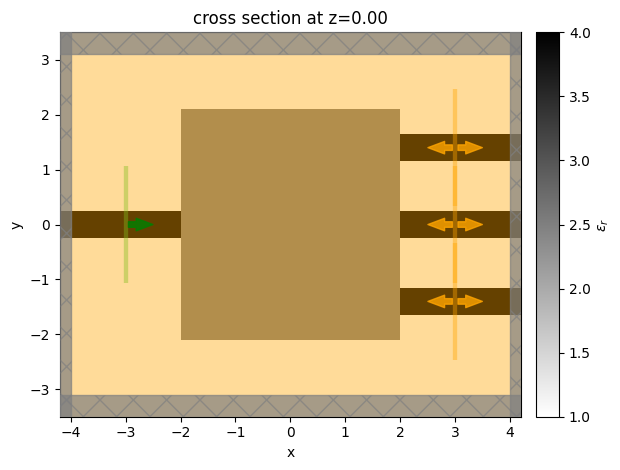

In [14]:
params0 = 0.5 * np.ones_like(params0)

sim = design.to_simulation(params=params0)
ax = sim.plot_eps(z=0)

It can be useful to run the initial problem to ensure it looks correct before optimizing. For convenience, the `to_simulation_data()` method generates the simulation and runs it through `web.run()` to return the `SimulationData`, which can be visualized.

In [15]:
sim_data = design.to_simulation_data(params=params0, task_name="inspect")

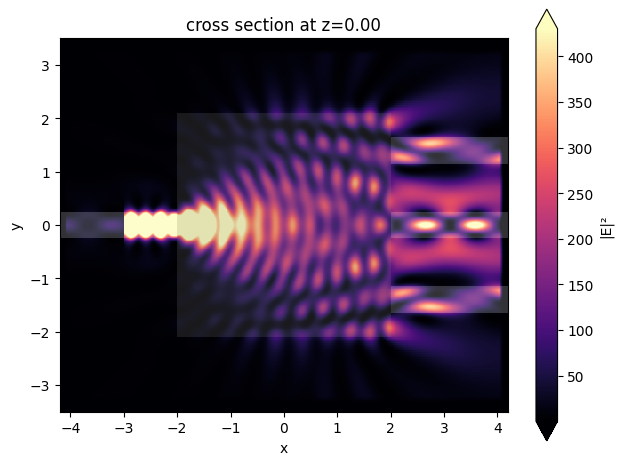

In [16]:
ax = sim_data.plot_field(field_mnt_name, field_name="E", val="abs^2")

## Optimization

Now that we've constructed our `InverseDesign` object, we can optimize it with gradient ascent. We first define the contribution that we want our simulation result to have in our objective function.

### Post-Process Function

The next step of this process is to define a post-processing function, which tells our optimizer how we want it to interpret a `SimulationData` that corresponds to this design. We write this as a regular python function that takes a `td.SimulationData` as first argument. The function can accept optional keyword arguments involving the optimization history for more control over the objective function. 

> Reminder that the objective function will be **maximized** by our objective, minus any penalty values from the `DesignRegion`. So the sign of this function should take this into account.

In this example, we will try to maximize the minimum power in each of the three output waveguides. This is to ensure that we get an even distribution of power and no ports are ignored.

First we will grab the power at each of the waveguides from the `SimulationData`. Then, we'll pass the negative of each power to a [softmax function](https://en.wikipedia.org/wiki/Softmax_function) to get a differentiable set of normalized weights for each of the ports, with more weight on the smallest values. We'll take the dot product of our powers with these weights and try to maximize this. Normalizing so that a "perfect" splitter gives a value of 1.

> Note: there are some utility functions included in the `tdi.utils` namespace that can make postprocessing a bit easier. Such as `utils.get_amps(sim_data, monitor_name, **sel_kwargs)`, and `util.sum_abs_squared(arr)`. To see all of these available currently, try `help(tdi.utils)`. We'll demonstrate some these in the function below, along with the (commented out) equivalent approach using `autograd`. 

> Note: If doing more complex operations in the postprocess function, be sure to use `autograd.numpy` instead of regular `numpy` to ensure that the function is differentiable by `autograd`.

In [17]:
import autograd.numpy as npa

def post_process_fn(sim_data: td.SimulationData, **kwargs) -> float:
    """Function called internally to compute contribution to the objective function from the data."""

    # grab the amplitudes for each of the output waveguide monitors
    amps = [tdi.utils.get_amps(sim_data, monitor_name=mnt.name, direction="+") for mnt in monitors_out]

    # compute the power at each of the output waveguides
    powers = [tdi.utils.sum_abs_squared(amp) for amp in amps]

    # # or, when written in more low-level syntax        
    # amps = [sim_data[mnt.name].amps.sel(direction="+") for mnt in monitors_out]
    # powers = [jnp.sum(abs(jnp.array(amp.values))**2) for amp in amps]
    
    powers = npa.array(powers)

    # get a set of weights picking out which powers are the lowest of the three
    softmin_weights = npa.exp(-powers) / npa.sum(npa.exp(-powers))

    # compute a normalized weighted sum of the output powers, weighting the "worst" ones the highest (softmin)
    return num_output_waveguides * npa.sum(powers * softmin_weights)

> Note: the extra `**kwargs` contain information passed during optimization about the history and the index of the step. They can be used to schedule changes into the post processing function as a function of the optimization state. We won't go into more detail here but future tutorials will explore how to use these for more advanced optimization.

### Optimizer

Next, we create `Optimizer` object to contain all of the parameters that the optimization algorithm will need. This object also provides a few different methods to perform the optimization in different circumstances.

> Note: For now, we only support the "Adam" optimization method (`AdamOptimizer`), but will implement other algorithms as needed later. Adam tends to work quite well for most applications.
> 
The optimizer accepts our `InverseDesign`, as well as various optimization parameters, such as the number of steps and learning rate, and parameters specific to the algorithm being implemented.

The `results_cache_fname` is an optional, but very useful argument that will tell the optimizer to save the optimization state to file at each iteration using `pickle`. It is good practice to include it in case the optimization gets stalled, which can happen in case of a bad internet connection, for example.

In a later section, we'll show how to conveniently load results from this file.


In [18]:
optimizer = tdi.AdamOptimizer(
    design=design,
    num_steps=10,
    learning_rate=0.1,
    results_cache_fname="data/invdes_history.hdf5",
)

### Running the Optimization

Finally, we can use `result = Optimizer.run(params0)` on our initial parameters to run the inverse design problem.

> Note, if you leave out the `params0`, we will start the optimization with an array containing all 0.5 values, which is usually a good choice unless there is a symmetry in your problem that you need to break to get the optimization started.

This will construct our combined objective function behind the scenes, including the penalties and our post-processing function, use `autograd` to differentiate it, and feed it to a gradient-descent optimizer that we maintain.


In [19]:
result = optimizer.run(params0=params0, post_process_fn=post_process_fn)

step (1/10)
	objective_fn_val = -4.895e-01
	grad_norm = 2.329e-01
	post_process_val = 3.105e-01
	penalty = 8.000e-01


step (2/10)
	objective_fn_val = -5.730e-01
	grad_norm = 1.453e-01
	post_process_val = 2.270e-01
	penalty = 8.000e-01


step (3/10)
	objective_fn_val = -4.012e-01
	grad_norm = 1.625e-01
	post_process_val = 3.243e-01
	penalty = 7.254e-01


step (4/10)
	objective_fn_val = 7.586e-02
	grad_norm = 1.818e-01
	post_process_val = 5.822e-01
	penalty = 5.063e-01


step (5/10)
	objective_fn_val = 2.878e-01
	grad_norm = 1.780e-01
	post_process_val = 6.913e-01
	penalty = 4.035e-01


step (6/10)
	objective_fn_val = 3.746e-01
	grad_norm = 1.656e-01
	post_process_val = 7.262e-01
	penalty = 3.515e-01


step (7/10)
	objective_fn_val = 4.968e-01
	grad_norm = 7.447e-02
	post_process_val = 8.161e-01
	penalty = 3.193e-01


step (8/10)
	objective_fn_val = 5.223e-01
	grad_norm = 1.311e-01
	post_process_val = 8.216e-01
	penalty = 2.993e-01


step (9/10)
	objective_fn_val = 6.036e-01
	grad_norm = 4.928e-02
	post_process_val = 8.885e-01
	penalty = 2.849e-01


step (10/10)
	objective_fn_val = 6.212e-01
	grad_norm = 6.699e-02
	post_process_val = 8.961e-01
	penalty = 2.748e-01


## Optimization Results

The result of an optimization run is stored as an `InverseDesignResult` object. This object has various fields storing information about the history of the optimization run, including the optimizer states, as well as a copy of the initial `InverseDesign` object.

### Loading an Optimization Result from Backup File
If your optimization run was interrupted before you could get the `result` object. You can load if from the `optimizer.results_cache_fname`, if it was defined before. This file gets saved at every iteration with the most up to date `InverseDesignResult` so it should have the most up to date history.

In [20]:
result = tdi.InverseDesignResult.from_file(optimizer.results_cache_fname)

### Continuing an Optimization Run

To continue an optimization run from where it left off, you can use `Optimizer.continue_run(results)`, passing in the `InverseDesignResult`. As the `InverseDesignResult` stores the previous states of the optimizer, it can continue the optimization without loss of information. The return value of this method will be a new copy of the `InverseDesignResult` with the combined data.

In [21]:
# change some optimization parameters, if desired, set new number of steps
optimizer = optimizer.updated_copy(num_steps=1, learning_rate=0.1)

# continue the run, passing in the latest result
result = optimizer.continue_run(result=result, post_process_fn=post_process_fn)

step (1/1)
	objective_fn_val = 6.317e-01
	grad_norm = 6.651e-02
	post_process_val = 8.994e-01
	penalty = 2.677e-01


> Note: A convenient way to continue an optimization in just one line is to use `Optimizer.continue_run_from_history()`. This method combines `.continue_run()` with the backup file in the `results_cache_fname` to continue a run from the history saved to disk.

### Analyzing and Exporting Results

The `InverseDesignResult` itself has a set of methods for analyzing results and exporting to various formats.

#### Plotting History

We can quickly view the optimization history, including the penalty and postprocessing function contributions.

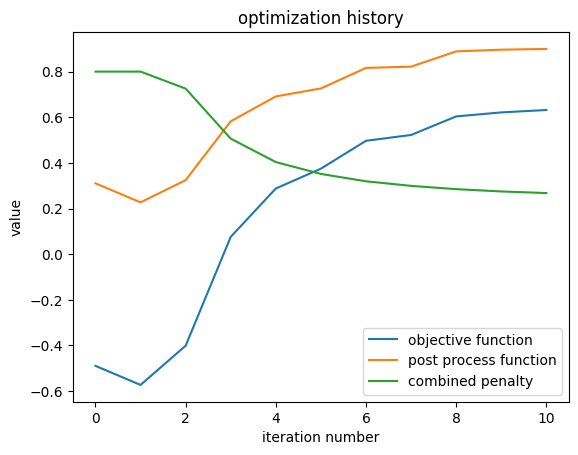

In [22]:
result.plot_optimization()
_ = plt.gca().set_title('optimization history')

#### Grabbing History Data

`InverseDesignResult` objects maintain a `history` dictionary that stores the various parameters over the course of the optimization.

They also have some methods to conveniently grab data from that history, as shown below:

In [23]:
history_keys = result.keys
history_penalty = result.history.get('penalty')
final_objective = result.get("objective_fn_val", index=-1)

print(f"result contains '.history' for: {tuple(history_keys)}")
print(f"penalty history: {history_penalty}")
print(f"final objective function value: {final_objective}")

result contains '.history' for: ('params', 'objective_fn_val', 'grad', 'penalty', 'post_process_val', 'opt_state')
penalty history: [0.7999999999999959, 0.7999999988189247, 0.7254198102399996, 0.5062962442562291, 0.4035487069134751, 0.35154869402675726, 0.31929636191627736, 0.2993055087705065, 0.2848840292864964, 0.27483525198019393, 0.26768013566244486]
final objective function value: 0.6316840928902361


Finally, we are able to quickly grab the last `Simulation` and `SimulationData` from the results, making it easy to plot final devices, field patterns, or export to GDS file.

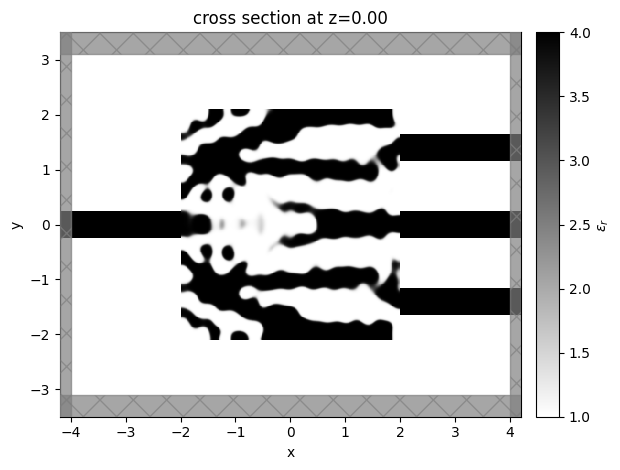

In [24]:
sim_last = result.sim_last
ax = sim_last.plot_eps(z=0, monitor_alpha=0.0, source_alpha=0.0)

> Note: to get the simulation at a specific index `i` in the history, call `sim_i = result.get_sim(index=i)`.

In [25]:
sim_data_last = result.sim_data_last(task_name="final_validation")

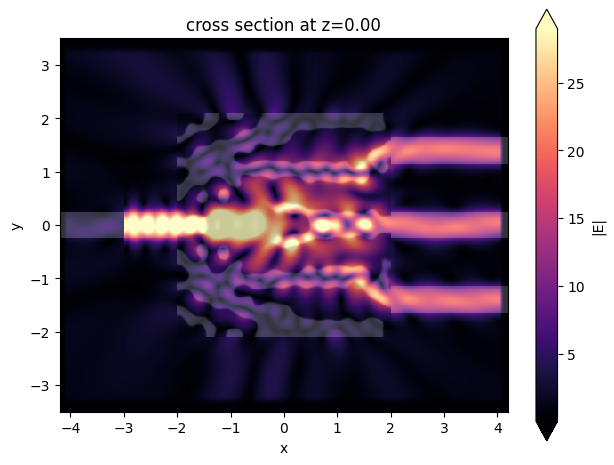

In [26]:
ax = sim_data_last.plot_field(field_mnt_name, field_name="E", val="abs")

#### Exporting to GDS

Use the regular GDS export functions defined in the `sim_last` to easily export to GDS.

In [27]:
sim_last.to_gds_file(
    fname="./misc/inv_des_demo.gds", 
    z=0, 
    frequency=freq0, 
    permittivity_threshold=2.5
)

## Multi-Simulation Objectives

In many cases, one would like to perform an optimization with more than one base simulation. For example, if optimizing a multi-port device, it is very common to have objective functions that share a single design region, but each simulation involves a source placed at a different port, to compute a scattering matrix, for example.

To handle this use-case, the `invdes` plugin includes an `InverseDesignMulti` class. This object behaves similarly to the `InverseDesign` class, except it allows for a set of multiple `td.Simulation` instances. Additionally, the `postprocess_fn` now accepts a list of `td.SimulationData` objects as first argument, which allows the user to write an objective function over all simulation results.

Here we'll run through a simple example, where we'll place a source at each of the 3 waveguides on the right (each in a different simulation) and then measure the sum of the power measured on the waveguide on the left. Note that this objective function is similar to the one we optimized earlier, but involves three separate simulations, just for demonstration purposes.

First, we'll switch up our sources and mode monitors.

In [28]:
mnt_name_left = "mode"

mnt_left = td.ModeMonitor(
    size=source.size,
    center=source.center,
    mode_spec=mode_spec,
    name=mnt_name_left,
    freqs=[freq0]
)

srcs_right = []

for mnt in monitors_out:
    src_right = source.updated_copy(
        size=mnt.size,
        center=mnt.center,
        direction="-",
    )
    srcs_right.append(src_right)

Make a simulation for each of the independent sources.

In [29]:
simulations = [
    simulation.updated_copy(sources=[src], monitors=[fld_mnt, mnt_left])
    for src in srcs_right
]

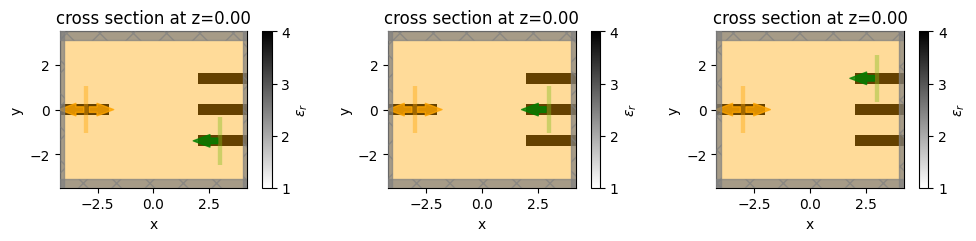

In [30]:
f, axes = plt.subplots(1,3,figsize=(10,4), tight_layout=True)
for ax, sim in zip(axes, simulations):
    sim.plot_eps(z=0, ax=ax)
plt.show()

We also need to construct a post-processing function that will tell the optimizer how to post process the data from each of the `simulations` into a single objective.


In [31]:
def post_process_fn(batch_data: dict[str, td.SimulationData]) -> float:
    """Grab the power going left at the single waveguide monitor"""
    power_left = 0.0
    for task_name, sim_data in batch_data.items():
        amps = tdi.utils.get_amps(sim_data, monitor_name=mnt_name_left, direction="-")
        power = tdi.utils.sum_abs_squared(amps)

        # # or, when written in more low-level syntax
        # amp = sim_data[mnt_name_left].amps.sel(direction="-")
        # power = abs(jnp.sum(jnp.array(amp.values)))**2
        
        power_left += power
    return power_left

We'll also specify the output monitor names for each of the simulations, to keep unnecessary warnings from popping up.

In [32]:
output_monitor_names = [[mnt_name_left], [mnt_name_left], [mnt_name_left]]

Finally, we combine everything into an `InverseDesignMulti` object.

In an analogy to the `InverseDesign` from the previous section, this object will generate a set of `td.SimulationData` objects under the hood and use `td.web.run_async` to run each of them in parallel.

After the simulations are run, the combined post-processing function will be applied to the combined data to give the final value, minus any penalties in the shared `DesignRegion`.

In [33]:
design_multi = tdi.InverseDesignMulti(
    design_region=design_region,
    simulations=simulations,
    task_name="invdes_multi",
    output_monitor_names=output_monitor_names,
    verbose=True,
)

To run this, let's make a new optimizer with this multi-design. We'll save the results to the same file as before.

In [34]:
optimizer = tdi.AdamOptimizer(
    design=design_multi,
    results_cache_fname="data/invdes_history.hdf5",
    learning_rate=0.12,
    num_steps=3,
)

And use the `continue_run_from_history()` to pick up where we left off.

In [35]:
results_multi = optimizer.continue_run_from_history(post_process_fn=post_process_fn)

Output()

13:47:11 UTC Started working on Batch containing 3 tasks.

13:47:20 UTC Maximum FlexCredit cost: 0.075 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

13:47:36 UTC Batch complete.

Output()

Output()

13:51:51 UTC Started working on Batch containing 3 tasks.

13:51:54 UTC Maximum FlexCredit cost: 0.075 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

13:52:14 UTC Batch complete.

Output()

step (1/3)
	objective_fn_val = 6.473e-01
	grad_norm = 4.683e-02
	post_process_val = 9.093e-01
	penalty = 2.620e-01


Output()

13:52:36 UTC Started working on Batch containing 3 tasks.

13:52:39 UTC Maximum FlexCredit cost: 0.075 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

13:53:00 UTC Batch complete.

Output()

Output()

13:56:37 UTC Started working on Batch containing 3 tasks.

13:56:40 UTC Maximum FlexCredit cost: 0.075 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

13:56:53 UTC Batch complete.

Output()

step (2/3)
	objective_fn_val = 6.627e-01
	grad_norm = 4.159e-02
	post_process_val = 9.202e-01
	penalty = 2.575e-01


Output()

13:57:16 UTC Started working on Batch containing 3 tasks.

13:57:19 UTC Maximum FlexCredit cost: 0.075 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

13:57:35 UTC Batch complete.

Output()

Output()

14:01:34 UTC Started working on Batch containing 3 tasks.

14:01:37 UTC Maximum FlexCredit cost: 0.075 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

14:01:54 UTC Batch complete.

Output()

step (3/3)
	objective_fn_val = 6.802e-01
	grad_norm = 3.095e-02
	post_process_val = 9.341e-01
	penalty = 2.539e-01


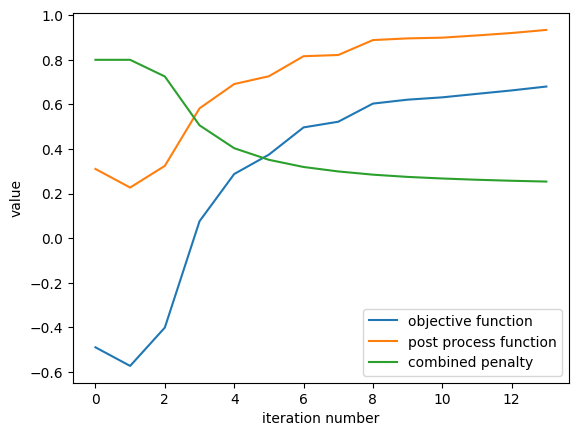

In [36]:
results_multi.plot_optimization()